In [9]:
# Libaries to import:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rcParams
import matplotlib.lines as mlines

In [10]:

# Dictionary to define the Stations to include in diagram
Station_dict = {
    "NND": "Nanardine",
    "NOJ": "Parkes North West Junction",
    "GBJ North": "Goobang Jct North",
    "GBJ": "Goobang Jct",
    "PKS": "Parkes",
    "GBD": "Gunningbland",
   # "PWF": "Parkes PN Terminal West Fork",
   # "PEF": "Parkes East Fork",
    "SCJ": "SCT Parkes",
    "FRA": "Mountain Industries Sdg",
    #"PSH": "Parkes South",
    "SG TOW": "South Goobang TOW",
    #"PKE": "Parkes M Frame"
}
 
# Order of Stations in graph 
ordered_stations = [
    "Nanardine",
     "Parkes North West Junction", 
     "Goobang Jct North",
    "Parkes",
    "Goobang Jct", 
    "SCT Parkes",
   #  "Parkes East Fork",
   #  "Parkes PN Terminal West Fork",
     "Gunningbland",
    #  "Parkes M Frame",
     "South Goobang TOW",
     #"Parkes South",
     "Daroobalgie"
]
ordered_stations = ordered_stations[::-1]
# Create a mapping of stations to numeric indices
station_order_dict = {station: idx for idx, station in enumerate(ordered_stations)}

# if there is any names you want to change add here:
station_mapping = {
    "Mountain Industries Sdg": "Daroobalgie"
}

In [11]:
# The keys in direction_colours refer to words inside that train names that i have used to colour the trains:

direction_colors = {
    "North": "#15828F",   # Northbound trains
    "South": "#00B37D",  # Southbound trains
    "West": "#7C6990", # Westbound trains
    "Grain": "#D05459",    # GT trains
    "East": "#7C6990"     # Assuming EB trains share the same color as GT
}

def get_train_color(train_name):
    for prefix, color in direction_colors.items():
        if prefix in train_name:
            return color
    return "black"  # Default color if no match is found

In [12]:

# HELPER FUNCTIONS
def combine_arrival_departure(data, arrival_col, departure_col):
    """
    Combines arrival and departure times into a single column.
    If they differ, creates two rows (one for arrival, one for departure).

    Parameters:
        data (pd.DataFrame): The original dataframe.
        arrival_col (str): The column name for arrival times.
        departure_col (str): The column name for departure times.

    Returns:
        pd.DataFrame: Transformed dataframe with combined times.
    """
    rows = []
    for _, row in data.iterrows():
        if row[arrival_col] != row[departure_col]:  # If times differ, create two rows
            rows.append({**row, 'Combined_Time': row[arrival_col], 'Event': 'Arrival'})
            rows.append({**row, 'Combined_Time': row[departure_col], 'Event': 'Departure'})
        else:  # If times are the same, create one row
            rows.append({**row, 'Combined_Time': row[arrival_col], 'Event': 'Both'})
    return pd.DataFrame(rows)

    # Customizing y-axis to show the time format
def format_seconds(x, pos):
    return str(timedelta(seconds=x))


In [13]:
# TRANSFORM TIMETABLE DATA FOR USE IN PLOT:
def timetable_conversion(file_name):
    Timetable_data = pd.read_csv(file_name, delimiter=',')
    # Select only the desired columns
    Timetable_data = Timetable_data[['Train', 'Station','Scheduled arrival [D HH:MM:SS]','Scheduled departure [D HH:MM:SS]']]
    Timetable_data['Train']=Timetable_data['Train'].astype(str)
    Timetable_data = Timetable_data[Timetable_data['Train'].notna()]
    Timetable_data = Timetable_data[Timetable_data['Station'].isin(Station_dict.values())]
    Timetable_data = combine_arrival_departure(
    Timetable_data,
    'Scheduled arrival [D HH:MM:SS]',
    'Scheduled departure [D HH:MM:SS]'
)

    # Convert 'Combined_Time' to seconds for plotting
    Timetable_data['Combined_Time_seconds'] = Timetable_data['Combined_Time'].apply(lambda x: pd.to_timedelta(x).total_seconds())
    #change names absed on inputed dict
    Timetable_data['Station'] = Timetable_data['Station'].replace(station_mapping)
    return Timetable_data

In [14]:
# USER INPUTS
file_name = 'Timetable - MBtest.csv'
output='50 Trains'
Timetable_data=timetable_conversion(file_name)

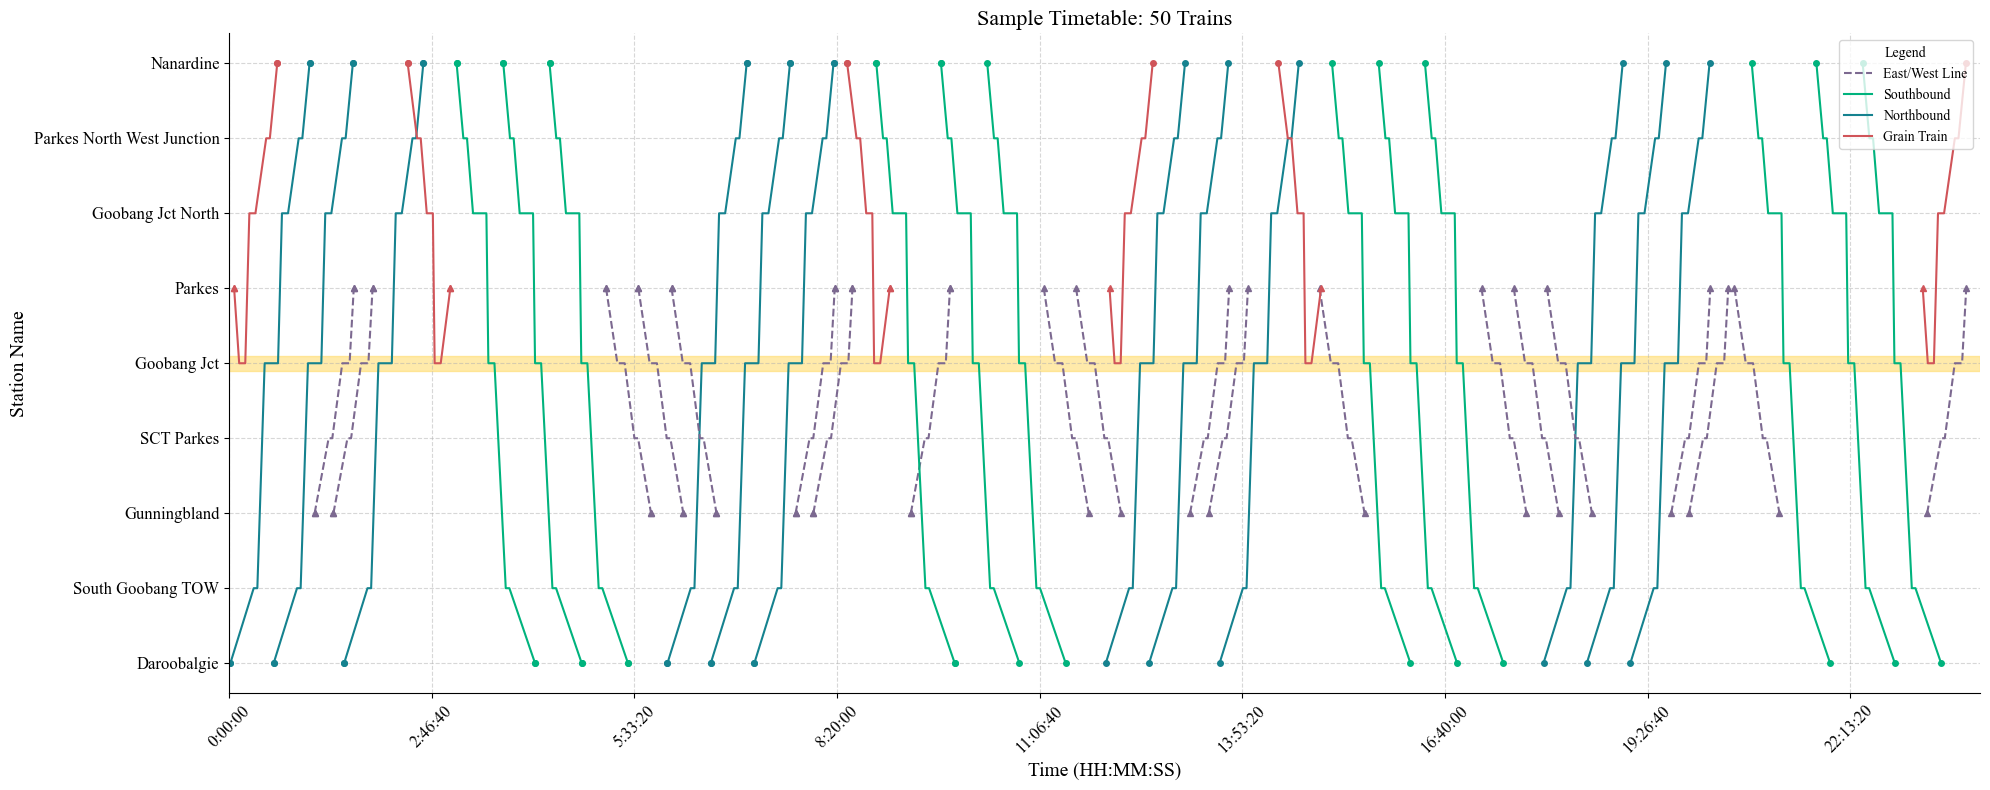

In [15]:

# Set Times New Roman globally
rcParams['font.family'] = 'Times New Roman'

# Create the plot
plt.figure(figsize=(20, 8))



# Loop through each train and plot its path
for train_number, group in Timetable_data.groupby('Train'):
    y_values = group['Station'].map(lambda y: station_order_dict.get(y, -1))
    train_color = get_train_color(train_number)
    # SET LINESTYLES:
    linestyle = '--' if train_color == direction_colors["West"] else '-' 
    # PLOT LINES: 
    plt.plot(group['Combined_Time_seconds'], y_values, color=train_color, linestyle=linestyle)
    # Add specific markers for Nanardine and Parkes
    for station, time in zip(group['Station'], group['Combined_Time_seconds']):
        if station in ['Nanardine','Daroobalgie']:  # Circle marker for Nanardine
            plt.plot(time, station_order_dict.get(station, -1), marker='o', color=train_color, markersize=4)
        elif station in ['Parkes','Gunningbland']:  # Triangle marker for Parkes
            plt.plot(time, station_order_dict.get(station, -1), marker='^', color=train_color, markersize=4)
     

# Highlighting the 'Goobang Jct' region
goobang_jct_index = station_order_dict.get('Goobang Jct', -1)  # Get the y-point for Goobang Jct

if goobang_jct_index != -1:
    plt.gca().axhspan(goobang_jct_index - 0.1, goobang_jct_index + 0.1, color='#FFD757', alpha=0.5)

# Format the x-axis to show time in HH:MM:SS
formatter = matplotlib.ticker.FuncFormatter(format_seconds)
plt.gca().xaxis.set_major_formatter(formatter)

# REORDER Y- AXIS
plt.gca().yaxis.set_major_locator(ticker.FixedLocator(range(len(ordered_stations))))
plt.gca().yaxis.set_major_formatter(ticker.FixedFormatter(ordered_stations))

# LEGEND

west_legend = mlines.Line2D([], [], color=direction_colors["West"], linestyle='--', label='East/West Line')
inland_legend = mlines.Line2D([], [], color=direction_colors["South"], linestyle='-', label='Southbound')
Northbound_leg = mlines.Line2D([], [], color=direction_colors["North"], linestyle='-', label='Northbound')
Grain_leg = mlines.Line2D([], [], color=direction_colors["Grain"], linestyle='-', label='Grain Train')

plt.legend(handles=[west_legend, inland_legend, Northbound_leg, Grain_leg], loc='upper right', title='Legend')
# Add labels and title
plt.xlabel('Time (HH:MM:SS)', fontsize=14)
plt.ylabel('Station Name', fontsize=14)
plt.title(f'Sample Timetable: {output}', fontsize=16)
plt.xticks(fontsize=12, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.gca().set_xlim(0, 86400)

# Remove Borders
for pos in ['right', 'top']: 
    plt.gca().spines[pos].set_visible(False) 

# Show the plot
plt.tight_layout()

plt.savefig(output, dpi=300)
plt.show()


In [16]:
Timetable_data.to_csv(f'Timetable_output {output}.csv')